## **1(a)** 


**Softmax Function :**

Softmax function is used as an activation fuction in output layers.Cross enthropy function is used in the softmax funtion.It keeps he values between 0 and 1 for activation.Morevover, sum of these values will be 1.
Formula for softmax function can be given as 
</br>
</br>

$ p_{k} = \frac{e^{fk}}{\sum_{j}^{}e^{fC}}$
</br>
</br>

**Negative Log-Likelyhood (NLL):**

The loss grows larger on every incorrect prediction, since the determined loss will be zero at that prediction and we sum the loss for all the correct predictions.Hence to optimize a loss function, NLL finds the local minima of that loss fucntion. It is inversely proportional to the no. of values. Negative Log-Likelyhood can be given as follows. 
</br>
</br>
$L_{y} = -log({y_{i}})$



## **1(b)** 

Suppose we are predicting a single continuous target variable t from
a vector x of inputs (the extension to multiple targets is straightforward). We shall
suppose that the conditional distribution p(t|x) is Gaussian, with an x-dependent
mean given by the output of a neural network model y(x,w), and with precision
(inverse variance) β
</br>
</br>
p(t|x,w, β) = N(t|y(x,w), β
−1).
</br>
</br>
Similarly, we shall choose a prior distribution over the weights w that is Gaussian of the form
</br>
</br>
p(w|α) = N(w|0, α−1I).
</br>
</br>
For an i.i.d. data set of N observations x1, . . . , xN, with a corresponding set of target
values D = {t1, . . . , tN}, the likelihood function is given by
</br>
</br>


p(D|w, β) =$\prod$ n=1
N(tn|y(xn,w), β
−1)
</br>
</br>
and so the resulting posterior distribution is then
</br>
</br>
p(w|D, α, β) ∝ p(w|α)p(D|w, β). (5.164)
</br>
</br>
which, as a consequence of the nonlinear dependence of y(x,w) on w, will be non-
Gaussian.
We can find a Gaussian approximation to the posterior distribution by using the
Laplace approximation. To do this, we must first find a (local) maximum of the
posterior, and this must be done using iterative numerical optimization. As usual, it
is convenient to maximize the logarithm of the posterior, which can be written in the form
</br>
</br>

ln p(w|D) = −α/2 wTw − β/2$\sum_{n=1}^{N}$n=1{y(xn,w) − tn}^2 + const
</br>
</br>
which corresponds to a regularized sum-of-squares error function. Assuming for
the moment that α and β are fixed, we can find a maximum of the posterior, which
we denote wMAP, by standard nonlinear optimization algorithms such as conjugate
gradients, using error backpropagation to evaluate the required derivatives.

# **2(a), 2(b), 2(c)**

In [ ]:

# Importing utility libraries

import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.models import Sequential
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import time
import PIL
from IPython import display
%matplotlib inline

In [ ]:
# Splitting the dataset
(X_train, y_train),(X_test, y_test ) = mnist.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
# Normalizing the dataset to between (-1, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5


In [ ]:
# Creating the bathches and shuffling the dataset
buffer_size = X_train.shape[0]
batch = 128
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch)

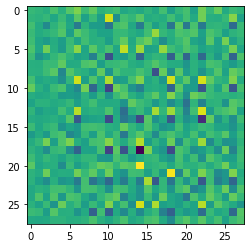

In [ ]:
def func_generator():
    model_gen = tf.keras.Sequential()
    number_nodes = 7 * 7 * 256
    model_gen.add(layers.Dense(number_nodes, use_bias=False, input_shape=(100,)))
    model_gen.add(layers.BatchNormalization())
    model_gen.add(layers.LeakyReLU(alpha=0.1))# Negative slop cefficient

    model_gen.add(layers.Reshape((7, 7, 256)))
    assert model_gen.output_shape == (None, 7, 7, 256) 

    model_gen.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model_gen.output_shape == (None, 7, 7, 128)
    model_gen.add(layers.BatchNormalization())
    model_gen.add(layers.LeakyReLU(alpha=0.1))

    model_gen.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model_gen.output_shape == (None, 14, 14, 64)
    model_gen.add(layers.BatchNormalization())
    model_gen.add(layers.LeakyReLU(alpha=0.1))
    """
    All the activation functions will be LeakyReLU in the layers,
    but last layer activation will always be "tahn"
    
    """
    model_gen.add(layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model_gen.output_shape == (None, 28, 28, 1)

    return model_gen


gen = func_generator()
input_noise = tf.random.normal(shape=[1, 100])
gen_img_out = gen(input_noise, training=False)
plt.imshow(gen_img_out[0, :, :, 0])
# print(gen_img_out.shape)

In [ ]:
def func_discriminator():
    model_disc = tf.keras.Sequential()
    model_disc.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model_disc.add(layers.LeakyReLU())
    model_disc.add(layers.Dropout(0.3))

    model_disc.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model_disc.add(layers.LeakyReLU())
    model_disc.add(layers.Dropout(0.3))

    model_disc.add(layers.Flatten())
    model_disc.add(layers.Dense(1))

    return model_disc


disc = func_discriminator()
disc_out = disc(gen_img_out)
print (disc_out)

tf.Tensor([[-0.00109579]], shape=(1, 1), dtype=float32)


In [ ]:
# calcululating loss to compute true values and  predicted values
loss_crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_gen(img_fk_out):
    return loss_crossEntropy(tf.ones_like(img_fk_out), img_fk_out)

def loss_disc(img_rl_out, img_fk_out):
    loss_rl_img = loss_crossEntropy(tf.ones_like(img_rl_out), img_fk_out)
    loss_fk_img = loss_crossEntropy(tf.zeros_like(img_fk_out), img_fk_out)
    loss = loss_rl_img + loss_fk_img
    return loss

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=tf.keras.optimizers.Adam(1e-4), disc_optimizer=tf.keras.optimizers.Adam(1e-4),
                                 generator=gen, discriminator=disc)

In [ ]:
dim_Noise = 100
EPOCHS = 10
samples = 20

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([samples, dim_Noise])

@tf.function # executes the compilation of the model
def train_step(images):
    noise = tf.random.normal([batch, dim_Noise])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_img_out = gen(noise, training=True)

      img_rl_out = disc(images, training=True)
      img_fk_out = disc(gen_img_out, training=True)

      generatorLoss = loss_gen(img_fk_out)
      discriminatorLoss = loss_disc(img_rl_out, img_fk_out)

    genGradients = gen_tape.gradient(generatorLoss, gen.trainable_variables)
    discGradients = disc_tape.gradient(discriminatorLoss, disc.trainable_variables)

    gen_optimizer = tf.keras.optimizers.Adam(1e-4)
    disc_optimizer = tf.keras.optimizers.Adam(1e-4)

    gen_optimizer.apply_gradients(zip(genGradients, gen.trainable_variables))
    tf.keras.optimizers.Adam(1e-4).apply_gradients(zip(discGradients, disc.trainable_variables))


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')

  plt.show()

In [ ]:
train(X_train, EPOCHS)


ValueError: ignored